# Advance HPC - Labwork 3

## Requirements

Make image RGB-to-gray converter using Numba CUDA

- Load an image from file (matplotlib’s imread)
- Flatten image into 1D array of RGB (`reshape(pixelCount, 3)`)
- Implement grayscale using CPU (for range)
- Implement grayscale using GPU
- Save/show the image after each grayscale to validate the result visually
- Use `time.time()` to measure speedup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import time

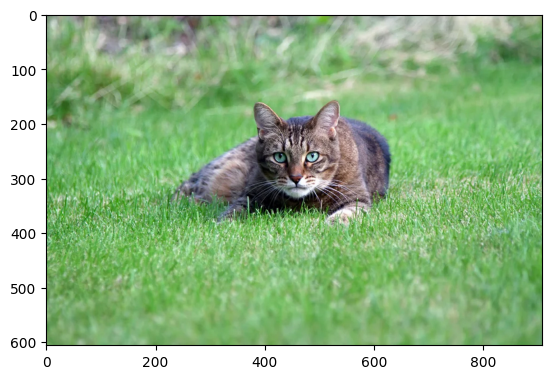

In [2]:
# load image
img = imread("original.png")
imgplot = plt.imshow(img)
plt.show()

In [3]:
img.shape

(606, 909, 4)

## Using GPU with 2D block size

In [4]:
from numba import cuda, float32

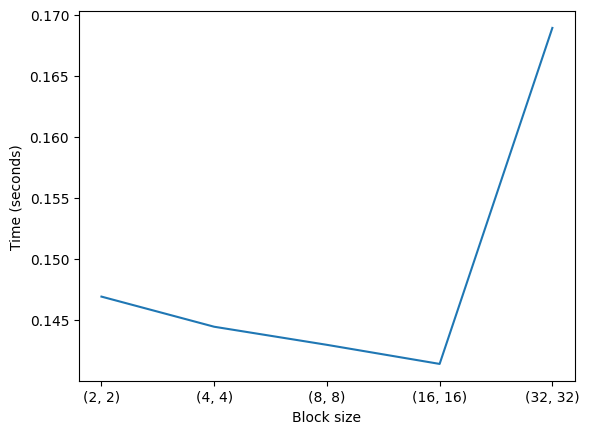

In [14]:
@cuda.jit
def grayscale_kernel_2d(src, dst):
	x, y = cuda.grid(2)
	if x < src.shape[0] and y < src.shape[1]:
		g = np.float32((src[x, y, 0] + src[x, y, 1] + src[x, y, 2]) / 3)
		dst[x, y, 0] = dst[x, y, 1] = dst[x, y, 2] = g

def to_grayscale_gpu_2d(img, block_size: tuple, kernel, show_result: bool = False):
	h, w, c = img.shape
	pixel_count = h * w
	grid_size_x = (w + block_size[0] - 1) // block_size[0]
	grid_size_y = (h + block_size[1] - 1) // block_size[1]
	grid_size = (grid_size_x, grid_size_y)
	rgb = np.ascontiguousarray(img[..., :3])

	devSrc = cuda.to_device(rgb)
	devDst = cuda.device_array((h, w, 3), dtype=np.float32)

	kernel[grid_size, block_size](devSrc, devDst)

	hostDst = devDst.copy_to_host()
	grayscale_img = hostDst.reshape(h, w, 3)
	# Display the grayscale image
	fig = plt.figure()
	plt.imshow(grayscale_img, cmap='gray')
	if show_result:
		plt.axis('off')
		plt.show()
	plt.imsave(f"grayscale_gpu_block_size_{block_size}.png", grayscale_img, cmap='gray')
	plt.close(fig)

# to_grayscale_gpu_2d(img, (8, 8), grayscale_kernel_2d, show_result=True)

block_sizes_to_test = [(2,2), (2,2), (4,4), (8,8), (16,16), (32,32), ]
time_results = []
for block_size in block_sizes_to_test:
    start = time.time()
    to_grayscale_gpu_2d(img, block_size, grayscale_kernel_2d, show_result=False)
    end = time.time()
    time_results.append(end - start)

fig = plt.figure()
plt.plot(time_results[1:])
plt.xlabel("Block size")
plt.ylabel("Time (seconds)")
plt.xticks([0,1,2,3,4], block_sizes_to_test[1:])
plt.show()
fig.savefig("block_size_vs_time.png", bbox_inches='tight')